In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

In [ ]:
import jax
from jax import vmap, grad
import jax.numpy as jnp
import jax.lax as lax
import matplotlib.pyplot as plt

import time

def softplus(x):
  return lax.log1p(lax.exp(x))
  # return lax.log(lax.add(lax.exp(x), 1.))

def squareplus(x, b=4.):
  return lax.mul(0.5, lax.add(x, lax.sqrt(lax.add(lax.square(x), b))))

def relu(x):
  return lax.max(0., x)

def d_squareplus(x, b):
  return (1/2) * (x / jnp.sqrt(x**2 + b) + 1)

def dd_squareplus(x, b):
  return (1/2) * (b / (x**2 + b)**(3/2))


In [ ]:
x = jnp.linspace(-12, 12, 1000001)
print(jax.devices())
fns = [jax.nn.softplus, softplus, jax.nn.elu, jax.nn.swish, squareplus, relu, jax.nn.relu]
for fn in fns:
  name = fn.__name__
  fn = jax.jit(fn)
  times = []
  for _ in range(1000):
    start = time.time()
    y = fn(x).block_until_ready()
    end = time.time()
    times.append(end - start)
  times = jnp.array(times)
  min_time = jnp.min(times)
  median_time = jnp.median(times)
  print(f'{name:20s}: {min_time * 1000:0.4f} ms')
  # print(f'{name:20s}: {min_time * 1000*1000:0.4f} μs')

[CpuDevice(id=0)]
softplus            : 3.6092 ms
softplus            : 3.3998 ms
elu                 : 1.9519 ms
silu                : 1.2047 ms
squareplus          : 0.6206 ms
relu                : 0.5622 ms
relu                : 0.5190 ms


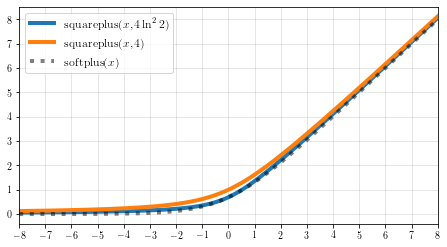

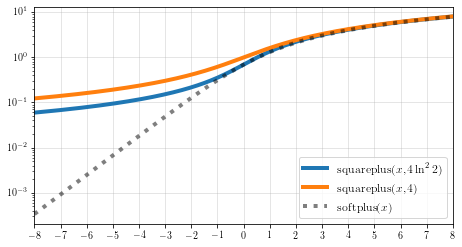

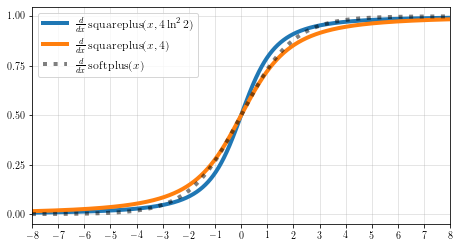

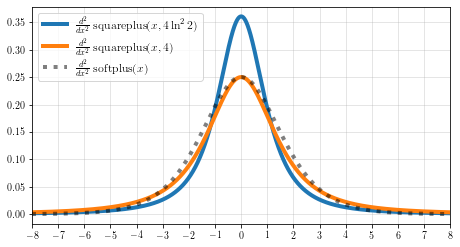

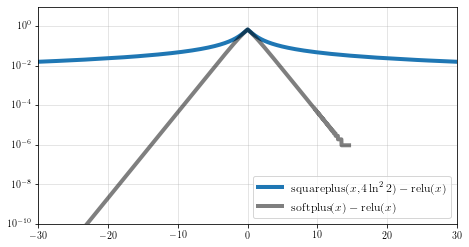

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

x = jnp.linspace(-8, 8, 10001)
linewidth=4
linestyle = "-"

b_special = 4 * jnp.log(2)**2

plt.figure(0, figsize=(7.5, 4))
plt.plot(x, squareplus(x, b=b_special), linestyle=linestyle, linewidth=linewidth, label=r'$\mathrm{squareplus}(x, 4\ln^2 2)$')
plt.plot(x, squareplus(x, b=4.), linestyle=linestyle, linewidth=linewidth, label=r'$\mathrm{squareplus}(x, 4)$')
plt.plot(x, softplus(x), 'k:', alpha=0.5, linewidth=linewidth, label=r'$\mathrm{softplus}(x)$')
plt.gca().set_xlim(x[0], x[-1])
plt.gca().set_xticks(jnp.arange(-8, 9))
plt.gca().set_yticks(jnp.linspace(0, 8, 9))
plt.gca().set_yticklabels([f'{int(x):d}' for x in jnp.linspace(0, 8, 9)])
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12)
plt.savefig('fn.pdf', bbox_inches = 'tight')

plt.figure(1, figsize=(7.5, 4))
plt.plot(x, squareplus(x, b=b_special), linestyle=linestyle, linewidth=linewidth, label=r'$\mathrm{squareplus}(x, 4\ln^2 2)$')
plt.plot(x, squareplus(x, b=4.), linestyle=linestyle, linewidth=linewidth, label=r'$\mathrm{squareplus}(x, 4)$')
plt.plot(x, softplus(x), 'k:', alpha=0.5, linewidth=linewidth, label=r'$\mathrm{softplus}(x)$')
plt.gca().set_xlim(x[0], x[-1])
plt.gca().set_xticks(jnp.arange(-8, 9))
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12, loc='lower right')
plt.gca().set_yscale('log')
plt.savefig('log_fn.pdf', bbox_inches = 'tight')

# Sigmoid
plt.figure(2, figsize=(7.5, 4))
plt.plot(x, vmap(grad(lambda x: squareplus(x, b=b_special)))(x), linestyle=linestyle, linewidth=linewidth,  label=r'$\frac{d}{dx}\,\mathrm{squareplus}(x, 4\ln^2 2)$')
plt.plot(x, vmap(grad(lambda x: squareplus(x, b=4.)))(x), linestyle=linestyle, linewidth=linewidth, label=r'$\frac{d}{dx}\,\mathrm{squareplus}(x, 4)$')
plt.plot(x, vmap(grad(softplus))(x), 'k:', alpha=0.5, linewidth=linewidth, label=r'$\frac{d}{dx}\,\mathrm{softplus}(x)$')
plt.gca().set_xlim(x[0], x[-1])
# plt.gca().set_ylim(0, 1)
plt.gca().set_xticks(jnp.arange(-8, 9))
plt.gca().set_yticks(jnp.linspace(0, 1, 5))
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12, loc='upper left')
plt.savefig('grad1.pdf', bbox_inches = 'tight')

# Logistic distribution
plt.figure(3, figsize=(7.5, 4))
plt.plot(x, vmap(grad(grad(lambda x: squareplus(x, b=b_special))))(x), linestyle=linestyle, linewidth=linewidth, label=r'$\frac{d^2}{dx^2}\,\mathrm{squareplus}(x, 4\ln^2 2)$')
plt.plot(x, vmap(grad(grad(lambda x: squareplus(x, b=4.))))(x), linestyle=linestyle, linewidth=linewidth, label=r'$\frac{d^2}{dx^2}\,\mathrm{squareplus}(x, 4)$')
plt.plot(x, vmap(grad(grad(softplus)))(x), 'k:', alpha=0.5, linewidth=linewidth, label=r'$\frac{d^2}{dx^2}\,\mathrm{softplus}(x)$')
plt.gca().set_xlim(x[0], x[-1])
plt.gca().set_xticks(jnp.arange(-8, 9))
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12, loc='upper left')
plt.savefig('grad2.pdf', bbox_inches = 'tight')

x = jnp.linspace(-30, 30, 10001)
plt.figure(4, figsize=(7.5, 4))
y = jax.nn.softplus(x) - relu(x)
idx = jnp.where(y>0)[0]
plt.plot(x, squareplus(x, b=b_special) - relu(x), linewidth=linewidth,  label=r'$\mathrm{squareplus}(x, 4\ln^2 2) - \mathrm{relu}(x)$')
plt.plot(x[idx[0]:idx[-1]], (jax.nn.softplus(x) - relu(x))[idx[0]:idx[-1]], 'k', alpha=0.5, linewidth=linewidth, label=r'$\mathrm{softplus}(x) - \mathrm{relu}(x)$')
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-10, 10)
plt.gca().set_xlim(x[0], x[-1])
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12)
plt.savefig('log.pdf', bbox_inches = 'tight')



In [ ]:
x = jnp.linspace(-1000, 1000, 100001)
assert jnp.abs(squareplus(0., 2.) - softplus(0.)) < 0.02  # Setting b=2 gets you close to softplus near the origin
assert squareplus(0., 4*jnp.log(2)**2) == softplus(0.)  # Setting b=4 log(2)^2 gets you exactly to softplus at the origin
assert jnp.all(squareplus(x, 0.) == relu(x)) # Setting b=0 gets you relu.
for b in [0.01, 1., 2., 4.]:
  assert grad(squareplus)(0., b) == grad(softplus)(0.) # Any b>0 matches the gradient of softplus near the origin
assert grad(grad(squareplus))(0., 4.) == grad(grad(softplus))(0.) # b==4 matches the second derivative of softplus near the origin.
assert jnp.all(squareplus(x, 4*jnp.log(2)**2 + 0.001) >= jax.nn.softplus(x)) # If b >= 4 log(2)^2, squareplus is bounded from below by softplus
assert squareplus(0., 4.) == 1

# It's a scale family.
x = jnp.linspace(-10, 10, 101)
for b in [0.1, 1., 3., 7.]:
  for a in [.1, .3, 1., 2., 3., 7.]:
    assert jnp.max(jnp.abs(squareplus(a*x, b)/a - squareplus(x, b/(a**2)))) < 1e-5

# Both approache relu in the limit.
assert softplus(80.) == 80.
assert softplus(-100.) == 0.
assert squareplus(10000.) == 10000.
assert softplus(-10000.) == 0.

# Derivatives are correct.
x = jnp.linspace(-10, 10, 100)
b = 2.7
assert jnp.max(jnp.abs(vmap(grad(lambda x: squareplus(x, b)))(x) - d_squareplus(x, b))) < 1e-7
assert jnp.max(jnp.abs(vmap(grad(grad(lambda x: squareplus(x, b))))(x) - dd_squareplus(x, b))) < 1e-7

# Second derivative is a t-distribution.
import tensorflow_probability as tfp
stud = tfp.distributions.StudentT(loc=0, scale=1, df=2)
x = jnp.linspace(-10, 10, 1001)
assert jnp.max(jnp.abs(dd_squareplus(x, 2) - stud.prob(x).numpy())) < 1e-6